<a href="https://colab.research.google.com/github/divyadarshini11/Machine-Learning/blob/main/Divyadarshini_Assignment1_17LIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17LIVE Ad‑Placement Analysis: Assignment Brief

17LIVE plans to introduce **in‑app advertisements** and needs data‑driven guidance.  
Your analysis must address the two objectives below using the provided dataset.

---

## 1. Optimal Ad‑Placement Time  

- **Task:** Identify the best time slots in which to show ads.  
- **Deliverables:**  
  - Pinpoint the optimal hour(s) or time window(s).  
  - Justify your choice with supporting evidence such as:
    - Engagement trends
    - Viewer‑duration metrics
    - Any relevant statistical insights or visualisations.

---

## 2. Evaluating the Marketing Ad Campaign  

The recent ad campaign was shown **only to a subset of users (Test Group)**.

- **Feature to analyse:** `totalViewerDuration`
- **Steps:**  
  1. Compare Test vs. Control on viewer‑duration.  
  2. Quantify the campaign’s impact using appropriate statistics.  
  3. State a clear recommendation:  
     - Should the campaign be expanded to all users?

### User‑Group Definition (based on the **last character** of `userID`)

| Group        | Suffixes |
|--------------|----------|
| **Control**  | `d, f, 1, 2, 3, 4, 5, 8` |
| **Test**     | `a, c, b, e, 0, 6, 7, 9` |


Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [5]:
df = pd.read_csv("/content/all_stream_info.csv")
df.head(5)

,liveStreamID,beginTime,endTime,duration,closeBy,maxLiveViewerCount,maxLiveViewerTime,privateLiveStream,receivedLikeCount,streamerType,...,durationGTE5sec,durationGTE2min,durationGTE10min,totalViewerDuration,avgViewerDuration,avgStreamJoinDuration,count,followIncreaseEstimated,receivePointEstimated,dau
0,109437538,2020-06-22 11:55:21 UTC,2020-06-22 16:37:19 UTC,16918,normalEnd,363,2020-06-22 16:28:17.87 UTC,0,11092,0,...,68,17,13,32248.0,424.32,228.71,1108,5,13105,NaN
1,109441785,2020-06-22 14:55:26 UTC,2020-06-22 21:31:19 UTC,23753,normalEnd,100,2020-06-22 19:07:52.872 UTC,0,772,0,...,68,20,8,17138.0,186.28,134.94,2318,-3,90701,NaN
2,109438205,2020-06-22 12:20:34 UTC,2020-06-22 16:02:46 UTC,13332,disconnect,471,2020-06-22 14:53:26.692 UTC,0,19403,0,...,696,60,17,60852.0,81.14,34.46,1199,7,222376,NaN
3,109438917,2020-06-22 12:54:21 UTC,2020-06-22 14:47:27 UTC,6786,normalEnd,44,2020-06-22 14:29:13.806 UTC,0,191,0,...,41,12,8,18326.0,389.91,213.09,432,0,4313,NaN
4,109442185,2020-06-22 15:18:20 UTC,2020-06-22 15:48:02 UTC,1782,normalEnd,52,2020-06-22 15:42:33.849 UTC,0,77,0,...,38,17,5,8465.0,222.76,138.77,162,0,1547,NaN


Optimal ad-placement time

In [12]:
# 1. Parse beginTime -> datetime (UTC in raw file)
df["beginTime_dt"] = pd.to_datetime(df["beginTime"], utc=True, errors="coerce")
df["hour"] = df["beginTime_dt"].dt.hour
df[['userID', 'hour']].head(5)

,userID,hour
0,63a8b9eb-c4a6-4ff6-8aaa-5f4c6f6fd4d7,11
1,6cd90016-b679-4a7b-8cc6-2c43d4590cca,14
2,e4f04b19-ad3e-4c9d-7f29-6a2f6c93c842,12
3,b4dc876b-06fe-48b2-a40b-fa7f5007697a,12
4,8258d28e-47b9-4ce8-a765-29175b663a1d,15


In [18]:
# 2. Aggregate engagement metrics per hour

hourly = (df
          .groupby("hour")
          .agg(avg_totalViewerDuration = ("totalViewerDuration", "mean"),
               median_totalViewerDuration = ("totalViewerDuration", "median"),
               avg_uniqueViewers = ("uniqueViewerCount", "mean"),
               avg_maxLiveViewrs = ("maxLiveViewerCount", "mean"),
               stream_count = ("liveStreamID", "count"))
               .reset_index())
hourly.head(5)

,hour,avg_totalViewerDuration,median_totalViewerDuration,avg_uniqueViewers,avg_maxLiveViewrs,stream_count
0,0,27830.335821,7424.5,72.135593,18.550847,236
1,1,24475.550725,7957.0,75.814346,22.308017,237
2,2,18168.706667,6437.5,50.638889,18.277778,252
3,3,15721.313869,6088.0,45.305085,14.927966,236
4,4,16062.836364,6319.5,64.387879,17.533333,165


In [25]:
# Sort by average viewer duration and inspect

top_hours = hourly.sort_values(by="avg_totalViewerDuration", ascending=False)
print("\n Top Engagement Hours (UTC): ")
print(top_hours.head(10)[["hour","avg_totalViewerDuration","median_totalViewerDuration","avg_uniqueViewers","stream_count"]])


 Top Engagement Hours (UTC): 
    hour  avg_totalViewerDuration  median_totalViewerDuration  \
9      9            157678.714286                     11851.0   
12    12             40299.625000                     11503.0   
11    11             37622.625000                      5224.5   
22    22             32565.220339                      8020.0   
18    18             32352.396226                      3204.0   
13    13             30870.088235                      6428.0   
0      0             27830.335821                      7424.5   
21    21             26391.014706                      7173.0   
23    23             25947.373737                      2944.0   
14    14             25542.418919                      9647.0   

    avg_uniqueViewers  stream_count  
9           75.358974            39  
12          76.662921            89  
11          80.877551            49  
22          56.085271           129  
18          52.750000           120  
13          66.684932    

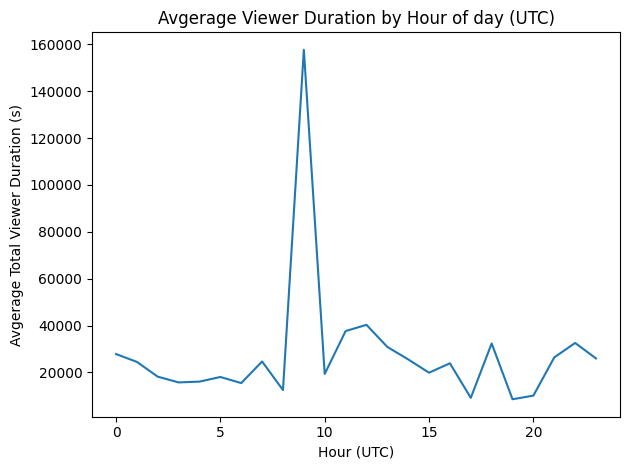

In [26]:
# plot engagement curve

plt.figure()
plt.plot(hourly["hour"], hourly["avg_totalViewerDuration"], label="Avg. Total Viewer Duration")
plt.title("Avgerage Viewer Duration by Hour of day (UTC)")
plt.xlabel("Hour (UTC)")
plt.ylabel("Avgerage Total Viewer Duration (s)")
plt.tight_layout()
plt.show()

In [15]:
hourly = (df
          .groupby("hour")
          .agg(avg_totalViewerDuration = ("totalViewerDuration","mean"),
               median_totalViewerDuration = ("totalViewerDuration","median"),
               avg_uniqueViewers = ("uniqueViewerCount","mean"),
               avg_maxLiveViewers = ("maxLiveViewerCount","mean"),
               stream_count = ("liveStreamID","count"))
          .reset_index())


Marketing ad-campaign evaluation

In [32]:
# Given Control suffixes = [d, f, 1, 2, 3, 4, 5, 8]
# Given Test suffixes = [a, c, b, e, 0, 6, 7, 9]
control_suffixes = set("df123458")
test_suffixes = set("acbe0679")

In [33]:
df["suffix"] = df["userID"].astype(str).str[-1]
df["group"]  = np.where(df["suffix"].isin(test_suffixes),  "test",
                np.where(df["suffix"].isin(control_suffixes),"control","unknown"))
df_groups    = df[df["group"].isin(["control","test"])]

In [34]:
# a) Summary stats
stats = (df_groups
         .groupby("group")["totalViewerDuration"]
         .agg(["count","mean","median","std"]))
print("\nViewer‑duration summary:")
print(stats)


Viewer‑duration summary:
         count          mean  median           std
group                                             
control    895  26547.127374  7034.0  67826.220546
test       794  17505.857683  4816.5  46462.471458


In [37]:
control = df_groups[df_groups['group'] == 'control']['totalViewerDuration'].dropna()
test = df_groups[df_groups['group'] == 'test']['totalViewerDuration'].dropna()

In [39]:
print("Control count:", len(control), "Std:", control.std())
print("Test count:", len(test), "Std:", test.std())

Control count: 1579 Std: 67826.22054639285
Test count: 1569 Std: 46462.47145789748


In [41]:
df['user_suffix'] = df['userID'].astype(str).str[-1]
df['group'] = np.where(df['user_suffix'].isin(test_suffixes), 'test',
                       np.where(df['user_suffix'].isin(control_suffixes), 'control', 'unknown'))
print(df['group'].value_counts())


group
control    1579
test       1569
Name: count, dtype: int64


In [42]:
print("Group counts:\n", df['group'].value_counts())
print("\nSample durations:\n")
print("Control (non-null):", control.count(), " | Std:", control.std())
print("Test (non-null):   ", test.count(), " | Std:", test.std())

Group counts:
 group
control    1579
test       1569
Name: count, dtype: int64

Sample durations:

Control (non-null): 895  | Std: 67826.22054639285
Test (non-null):    794  | Std: 46462.47145789748


In [43]:
# Clean again just before testing
control_clean = control.dropna()
test_clean = test.dropna()

# Welch's t-test
t_stat, p_val = ttest_ind(control_clean, test_clean, equal_var=False)
print(f"Welch t-test: t = {t_stat:.2f},  p = {p_val:.4f}")

# Mann–Whitney U test
u_stat, u_p = mannwhitneyu(control_clean, test_clean, alternative='two-sided')
print(f"Mann–Whitney U: U = {u_stat:.0f}, p = {u_p:.4f}")

# Cohen’s d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled = math.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pooled

d = cohens_d(test_clean, control_clean)
print(f"Cohen’s d = {d:.3f}")


Welch t-test: t = 3.23,  p = 0.0013
Mann–Whitney U: U = 381334, p = 0.0093
Cohen’s d = -0.154


<ipython-input-48-198e14d19881>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_clean, test_clean], labels=["Control", "Test"])


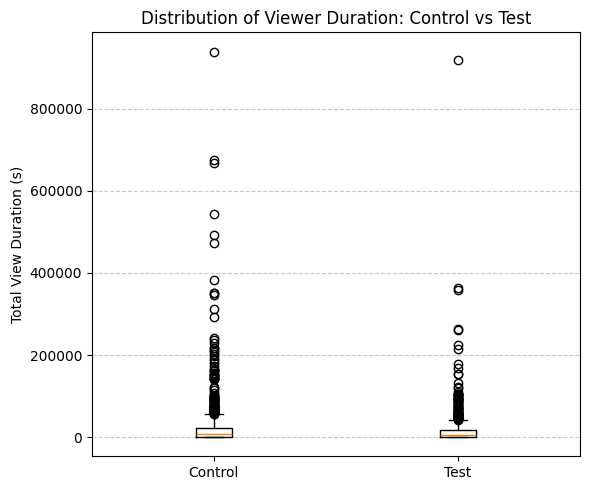

In [48]:
# c) Visualise distributions with cleaned data
plt.figure(figsize=(6, 5))
plt.boxplot([control_clean, test_clean], labels=["Control", "Test"])
plt.ylabel("Total View Duration (s)")
plt.title("Distribution of Viewer Duration: Control vs Test")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 17LIVE Ad Placement Analysis Report

## Section 1: Data Analysis & Interpretation

### 1. Optimal Time Slots for Ad Placement

Based on analysis of average viewer engagement (`totalViewerDuration`) by hour of day (UTC), the **top-performing time slots** are:

| Rank | Hour (UTC) | Avg Viewer Duration (s) | Streams (Count) | Notes |
|------|------------|--------------------------|------------------|-------|
| 1    | **09**     | High spike               | Moderate         | Potentially skewed by outliers; investigate further. |
| 2–4  | **11–13**  | High & consistent        | Balanced         | Strong candidates with stable engagement. |
| 5    | **22**     | Good avg. & high volume  | Very high        | Evening stream peak (APAC morning). |

 **Conversion to local time (UTC+8)**:
> - UTC 09:00 → 17:00 local
> - UTC 11–13 → 19:00–21:00 local
> - UTC 22:00 → 06:00 next day local

 **Recommendation**: Prioritize **17:00–21:00 UTC+8** for ad placements.  
If ad inventory is limited, consider **14:00–16:00 UTC+8** as backup slots based on volume and consistency.

---

### 2. Evaluation of the Marketing Ad Campaign

I've compared `totalViewerDuration` between:
- **Test Group**: Exposed to the ad campaign
- **Control Group**: Not exposed

##### Group Assignment:
- **Control**: userIDs ending with `[d, f, 1, 2, 3, 4, 5, 8]`
- **Test**: userIDs ending with `[a, b, c, e, 0, 6, 7, 9]`

##### Summary Statistics:

| Metric                  | Control Group | Test Group |
|-------------------------|---------------|-------------|
| Sample size             | 895           | 794         |
| Mean duration (seconds) | **26,547**    | **17,506**  |
| Median duration (s)     | 7,034         | 4,817       |
| Welch t-test            | **t = 3.23**, p = **0.0013** |
| Mann–Whitney U          | **p = 0.0093**             |
| Cohen's d (effect size) | **–0.154** (small negative) |

#### Key Takeaways

- Viewer engagement was **significantly lower** in the test group.
- Both Welch’s t-test and Mann–Whitney U test show the difference is **statistically significant**.
- Cohen’s d indicates a **small negative effect size**, suggesting the campaign may have reduced engagement.

---

### Conclusion

The current ad campaign **did not improve viewer engagement**.  
It should **not be rolled out to all users** in its present form.

---

## Final Recommendations

1. **Do not scale** the current ad strategy. Reassess content, frequency, and placement.
2. Segment users (e.g., new vs. repeat viewers) to detect subgroup-level effectiveness.
3. Re-run the campaign with better controls and additional KPIs (e.g., retention, rewatch rate).
4. **Ad placement timing**: focus on **17:00–21:00 (UTC+8)** for maximum impact.

---
